# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset, and then work our way up to ImageNet!

For this homework we will train a classifier for Tiny Imagenet which you can read about here https://tiny-imagenet.herokuapp.com/ but don't bother downloading it just yet.

A note on file paths: Last homework, we used the homework1 folder. That was a mistake as it was technically homework 0. You may want to rename the folder from last time to homework0 before you begin.

# Part 0: Initial Setup
You should recognize this code from last time.


In [1]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 0.4.1
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'  'Team Drives'


# Part 1: Upload the Dataset
Run this code to navigate to the BASE_PATH directory and upload the homework1.tar file inside the BASE_PATH, then extract it.

Have a look at pt_util. We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.


In [3]:
!pwd

BASE_PATH = '/gdrive/My Drive/colab_files/homework1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget http://pjreddie.com/media/files/homework1.tar
    !tar -xvf homework1.tar
    !rm homework1.tar

#os.chdir('/content')
!ls

print(os.listdir(DATA_PATH))

/content
/content
sample_data
imagenet128	 imagenet_full	plot02.png  __pycache__
imagenet128.tar  plot01.png	pt_util.py  tiny_imagenet
['train.h5', 'val.h5', 'class_names.txt', 'checkpoints']


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util
import matplotlib.pyplot as plt
import os

# Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try. Have a look at https://github.com/pytorch/examples/blob/master/mnist/main.py for a basic neural network implementation.


- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

Additionally, the current saving function always saves the latest results. You may want to modify it to only save the results if they have the highest test accuracy. Please make this modification.



In [0]:
class myLinearClassifier(torch.nn.Module):
    
    def __init__(self):
        super(myLinearClassifier, self).__init__()
        
        self.fc1=nn.Linear(64*64*3, 200)
    
    def forward(self, x):
        
        batch_size=x.shape[0]
        x=x.view(-1, 3*64*64)
        
        out=self.fc1(x)
        return out
        


class mySimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (256, 64, 64)
    
    def __init__(self):
        super(mySimpleCNN, self).__init__()
       
        #The first layer has a convultional network, a batch norm layer
        #
        self.conv_layers = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(), 
          nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), 
          nn.ReLU(), 
          nn.MaxPool2d(kernel_size=2, stride=1),
          nn.Dropout2d(p=0.25),
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=0.25),
          )
        
        self.fc_layers = nn.Sequential( 
          nn.Linear(8*8*64, 256),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(256,200)
          )
        
        
    def forward(self, x):
        
        batch_size=x.shape[0]
        #print("printing input")
        #print(x)
        
        out = self.conv_layers(x)
        #print("after after 1st conv layer")
        #print(out.shape)
        
        out = out.view(-1, 64 * 8 *8)
        #print("after flattening")
        #print(x.shape)
        
        out = self.fc_layers(out)
        #print("printing after 1st fc layer")
        #print(out.shape)
        
        return(out)
      
      
      
class myOtherCNN(torch.nn.Module):
    
    #Our batch shape for input x is (256, 64, 64)
    
    def __init__(self):
        super(myOtherCNN, self).__init__()
        
        self.conv_layers =nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Dropout2d(p=0.25),
          nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=2),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Dropout2d(p=0.25),        
        )
        
        self.fc_layers=nn.Sequential(
          nn.Linear(16*16*128, 512),  
          nn.ReLU(), 
          nn.Dropout(p=0.5),
          nn.Linear(512, 200)
        )
        
    def forward(self, x):
        batch_size=x.shape[0]
        out = self.conv_layers(x)
        out = out.view(-1, 128 * 16 *16)
        out=self.fc_layers(out)
        return out
        
        

In [0]:

#class TinyImagenetNet(myLinearClassifier):
#class TinyImagenetNet(mySimpleCNN):
class TinyImagenetNet(myOtherCNN):

    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        # TODO save the model if it is the best
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy
        #raise NotImplementedError('Need to implement save_best_model')

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [0]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    total_loss=0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            """
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            """
        total_loss=total_loss+loss
    total_loss=total_loss/(batch_idx+1)
    return total_loss

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            #print("yo here")
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                """
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
                """
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    
    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #test_loss, correct, len(test_loader.dataset), test_accuracy))
    #print("yo man")
    if return_images:
        return correct_images, correct_values, error_images, predicted_values, gt_values, test_loss, test_accuracy
    return test_loss, test_accuracy

# PART 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be acecces a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [0]:
import os
!pwd
print(os.getcwd())

# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        # TODO Implement data loading.
        
        self.hf = h5py.File(h5_file,  'r')
        self.transform=transform
        
        print(list(self.hf.keys()))
        
        #self.labels=self.hf['labels'][()]
        #self.images=self.hf['images'][()]
        #print(self.labels.shape)
        #print(self.labels.dtype)
        #print(self.images.shape)
        #print(self.images.dtype)
        
        #print(type(self.labels))
        #print(type(self.images))
        
        show=0
        if show:
          plt.imshow(self.hf['images'][()][0])
        
        #print(self.images[0])
        #print(self.labels[0])
        
        #raise NotImplementedError('Need to implement the data loading')

    def __len__(self):
        # TODO Implement the length function
        print(self.hf['labels'].shape[0])
        return self.hf['labels'].shape[0]
        #raise NotImplementedError('Need to return the lengeth of the dataset')

    def __getitem__(self, idx):
        # TODO implement the getitem function
        # You should return a tuple of:
        #    a torch tensor containing single image in CxHxW format and
        #    the label as a single tensor scalar.
        #raise NotImplementedError('Need to implement the data loading')
        data=self.hf['images'][()][idx]
        label=self.hf['labels'][()][idx]
        label=torch.from_numpy(label).long()
        
        if self.transform:
            data = self.transform(data)
            
        #print(data.type())
        #print(data.shape)
        
        #print(label.type())
        #print(label.shape)
        
        return (data, label)


##Sanity check
filename=os.path.join(DATA_PATH,  'train.h5')
mydataset=H5Dataset(filename)
mydata, mylabel = mydataset.__getitem__(0)

print(mylabel)


/gdrive/My Drive/colab_files/homework1
/gdrive/My Drive/colab_files/homework1
['images', 'labels']
tensor([0])


The tiny ImageNet dataset consists of a training set of 100,000 images  and a test/validation set of 10,000 images from 200 different classes of objects. All images in the tiny ImageNet are $64\times 64$. Run the below code to see few sample images.

**Why Data Augmentation ?**

There are 500 images per class in tiny ImageNet dataset. This makes the tiny ImageNet to be considered
as a small dataset if we’re training deep neural networks
on them. To overcome overfitting, we need an augmentation
method to increase the size of the dataset

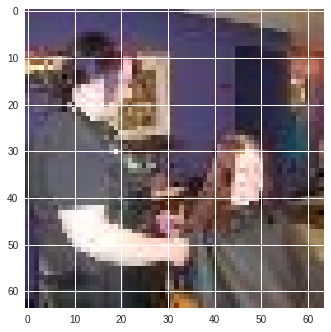

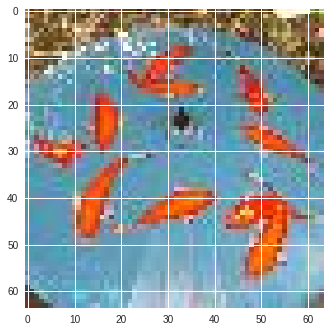

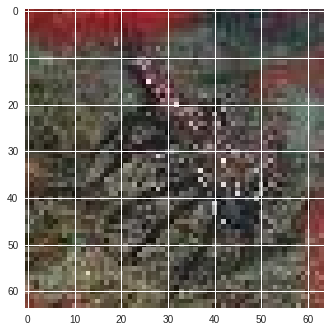

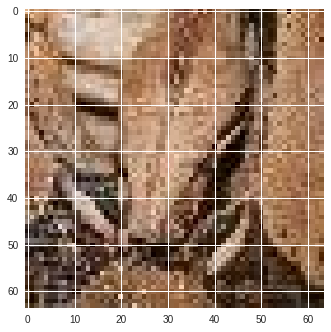

In [0]:
filename=os.path.join(DATA_PATH, 'train.h5')
hf = h5py.File(filename,  'r')

for i in np.random.randint(low=0, high=100000, size=4):
  plt.imshow(hf['images'][()][i])
  plt.show()
  
hf.close()

# Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [0]:
"""
Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
"""

"""
Normalization does helps CNN perform better.
Normalization helps get data within a range and reduces 
the skewness which helps learn faster and better
"""

"""
first convert to PIL Image and then apply all the transforms because
they need PIL image as input
"""

transform_type=0

if transform_type==0:
  train_transforms = transforms.Compose( 
    [transforms.ToPILImage(), transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  test_transforms = transforms.Compose( 
    [transforms.ToPILImage(), transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  
elif transform_type==1:  
  train_transforms = transforms.Compose( 
    [transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  test_transforms = transforms.Compose( 
    [transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)

_, _ = data_train.__getitem__(0)

['images', 'labels']
['images', 'labels']


# Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


In [15]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
EPOCHS = 9
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
PRINT_INTERVAL = 200 
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log.pkl'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]


indices=range(0, data_train.__len__())
train_sampler=torch.utils.data.RandomSampler(indices)

indices=range(0, data_test.__len__())
test_sampler=torch.utils.data.RandomSampler(indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, sampler = train_sampler, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, sampler=test_sampler, **kwargs)


print(train_loader.__len__())
print(test_loader.__len__())
print("here")

train_loss_list = []
test_loss_list = []
test_accuracy_list = []

model = TinyImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
start_epoch=0

# You may want to define another default for your log data depending on how you save it.
log_data = pt_util.read_log(LOG_PATH, [])
print(log_data)
print("-------------------------")

test(model, device, test_loader)

#correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
#correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
#error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))


#pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
#pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])



try:
    for epoch in range(start_epoch, EPOCHS + 1):
        my_train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        #correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        my_test_loss, my_test_accuracy = test(model, device, test_loader)
        # TODO define otssssher things to do at the end of each loop like logging and saving the best model.
        train_loss_list.append(my_train_loss)
        test_loss_list.append(my_test_loss)
        test_accuracy_list.append(my_test_accuracy)

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    # Always save the most recent model, but don't delete any existing ones.
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
    
    # Show some current correct/incorrect images.
    
    #correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    #error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    #pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    #pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


Using device cuda
num cpus: 2
100000
10000
782
79

Test set: Average loss: 5.2995, Accuracy: 23/10000 (0%)

Fri Nov  02 01:12:12 2018 Train Epoch: 0 [0/100000 (0%)]	Loss: 5.220220
Fri Nov  02 02:31:43 2018 Train Epoch: 0 [25600/100000 (26%)]	Loss: 6.652414
Fri Nov  02 03:55:31 2018 Train Epoch: 0 [51200/100000 (52%)]	Loss: 5.980055
Fri Nov  02 05:15:54 2018 Train Epoch: 0 [76800/100000 (77%)]	Loss: 5.045121

Test set: Average loss: 4.1138, Accuracy: 1477/10000 (15%)

Fri Nov  02 06:47:32 2018 Train Epoch: 1 [0/100000 (0%)]	Loss: 5.130276
Fri Nov  02 08:03:24 2018 Train Epoch: 1 [25600/100000 (26%)]	Loss: 4.801850
Fri Nov  02 09:22:08 2018 Train Epoch: 1 [51200/100000 (52%)]	Loss: 4.493137
Fri Nov  02 10:27:45 2018 Train Epoch: 1 [76800/100000 (77%)]	Loss: 4.277292

Test set: Average loss: 3.6091, Accuracy: 2175/10000 (22%)

Fri Nov  02 11:38:14 2018 Train Epoch: 2 [0/100000 (0%)]	Loss: 4.135633
Fri Nov  02 12:12:12 2018 Train Epoch: 2 [25600/100000 (26%)]	Loss: 3.727331
Fri Nov  02 13:

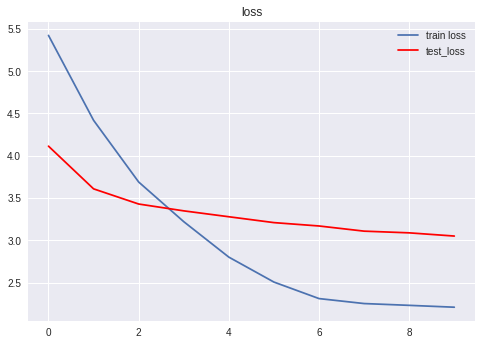

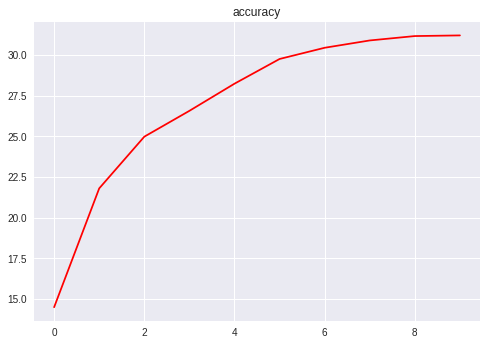

In [0]:
#Plot train and test losses

plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test_loss', c='r')
plt.title('loss')
plt.legend()
plt.savefig('plot01.png', bbox_inches='tight')
plt.show()

plt.plot(test_accuracy_list, c='r')
plt.title('accuracy')
plt.savefig('plot02.png', bbox_inches='tight')
plt.show()


# Part 6: ImageNet!
ImageNet is the big granddaddy of supervised vision datasets. It's the dataset that got the whole deep learning train running. We thought it would be fun for you guys to try your hand at it.

A few notes:
- Downloading ImageNet should take about 7 minutues. Extracting should take another 7 minutes. So run this code, then go have a coffee or whatever.
- The data will be removed after 24 hours or so. That's just how Colab works. Each time you reset the environment, you will also have to redownload ImageNet. 
    - I would recommend against storing it on your on Google Drive though as that is way slower to read during training.
    - Through extensive testing, we have found that the fastest way to get the data is the code we provide (faster than saving to google drive, uploading by hand, etc.) 
- Reading images directly with PIL seems to have issues on Colab. Instead try cv2.imread.
    - cv2.imread returns images in bgr order. To go from bgr -> rgb, use    `im = im[:, :, ::-1]`
- The images are provided such that the minimum side length is at least 128 unless the original image was too small for it to be shrunk.
    - transforms.Resize will be your friend
- It seams you cannot use a batch size > 64 x 128 x 128 x 3 while still using multiprocessing due to Colab limitations. You can use larger batches if you set num_workers = 0, but it will be much slower.
- This dataset has 1000 classes, whereas Tiny ImageNet only had 200.
- You will probably want to save your results more than once every epoch since Colab may spurriously shut down your session.
- We know this takes a long time to run. Try leaving it overnight. We don't expect you to get state-of-the-art performance.
- `glob.glob` is a good Python function for reading lots of folder/file names, but it does not return a sorted list.




In [0]:
# Downloads and extracts the data

if not os.path.exists('imagenet128'):
    !echo $(date +%x_%r)
    !gsutil cp gs://imagenet-cropped/imagenet128.tar .
    !echo $(date +%x_%r)
    !tar -xf imagenet128.tar
    !echo $(date +%x_%r)
    !ls imagenet128/train | head -4
    !echo "completed"

In [0]:
!pwd
!ls
!ls ./imagenet128

/gdrive/My Drive/colab_files/homework1
imagenet128	 imagenet_full	plot02.png  __pycache__
imagenet128.tar  plot01.png	pt_util.py  tiny_imagenet
imagenet_synsets.json  train  val


In [0]:
# Sets up synset data. Have a look at what is in these dictionaries as they may help you with debugging.
import json
imagenet_synset_data = json.load(open('imagenet128/imagenet_synsets.json'))
synset_id_to_cls = {val['id']: int(key) for key, val in imagenet_synset_data.items()}
print(synset_id_to_cls)

{'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9, 'n01530575': 10, 'n01531178': 11, 'n01532829': 12, 'n01534433': 13, 'n01537544': 14, 'n01558993': 15, 'n01560419': 16, 'n01580077': 17, 'n01582220': 18, 'n01592084': 19, 'n01601694': 20, 'n01608432': 21, 'n01614925': 22, 'n01616318': 23, 'n01622779': 24, 'n01629819': 25, 'n01630670': 26, 'n01631663': 27, 'n01632458': 28, 'n01632777': 29, 'n01641577': 30, 'n01644373': 31, 'n01644900': 32, 'n01664065': 33, 'n01665541': 34, 'n01667114': 35, 'n01667778': 36, 'n01669191': 37, 'n01675722': 38, 'n01677366': 39, 'n01682714': 40, 'n01685808': 41, 'n01687978': 42, 'n01688243': 43, 'n01689811': 44, 'n01692333': 45, 'n01693334': 46, 'n01694178': 47, 'n01695060': 48, 'n01697457': 49, 'n01698640': 50, 'n01704323': 51, 'n01728572': 52, 'n01728920': 53, 'n01729322': 54, 'n01729977': 55, 'n01734418': 56, 'n01735189': 57, 'n01737021': 58, 'n0173

In [0]:
#playing with imagenet_synset_data
print(dir(imagenet_synset_data)) #items #keys #fromkeys #values
print(imagenet_synset_data.keys()) #keys are just numbers from 0 to 999. Each representing a class
print(imagenet_synset_data.values())
print(list(imagenet_synset_data.values())[0]) #convert to list that makes it subscriptable
print(list(imagenet_synset_data.values())[0]['label']) #label of the zeroth item in the list
print(list(imagenet_synset_data.values())[0]['id']) #id of the zeroth element in the list
#the id corresponds to the folder in which all the corresponding images are located

print(imagenet_synset_data.items()) #each item is a key value pair
print(imagenet_synset_data.__len__())
print(imagenet_synset_data.__iter__())

print(synset_id_to_cls)

['__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '8

In [0]:
#Let's see what is inside the train subfolder
print(os.listdir('./imagenet128/train'))

print(os.listdir('./imagenet128/train/n04235860'))

mylist = os.listdir('./imagenet128/train') # dir is your directory path

['n04235860', 'n04417672', 'n02814860', 'n02174001', 'n02672831', 'n02051845', 'n03710193', 'n04335435', 'n02325366', 'n02749479', 'n02091831', 'n07730033', 'n03208938', 'n01737021', 'n02791270', 'n03935335', 'n04476259', 'n02002724', 'n04147183', 'n04485082', 'n04229816', 'n07716906', 'n02281406', 'n02130308', 'n03843555', 'n01601694', 'n11879895', 'n02134418', 'n03109150', 'n02835271', 'n04208210', 'n02974003', 'n07718747', 'n01855032', 'n02093991', 'n03481172', 'n02120505', 'n03447721', 'n03942813', 'n02088466', 'n04370456', 'n02002556', 'n02093647', 'n02321529', 'n04141975', 'n03706229', 'n04111531', 'n03770679', 'n04044716', 'n04612504', 'n02099429', 'n03670208', 'n03937543', 'n04146614', 'n03832673', 'n03485794', 'n02966193', 'n02112018', 'n02454379', 'n07579787', 'n03095699', 'n03160309', 'n01910747', 'n03372029', 'n07693725', 'n12985857', 'n02111889', 'n02105251', 'n03016953', 'n02950826', 'n04136333', 'n03417042', 'n04560804', 'n02096294', 'n15075141', 'n02101388', 'n02101556'

imagenet128/train/n04235860/n04235860_1335.JPEG
['imagenet128', 'train', 'n04235860', 'n04235860_1335.JPEG']
797
(128, 188, 3)
<class 'numpy.ndarray'>


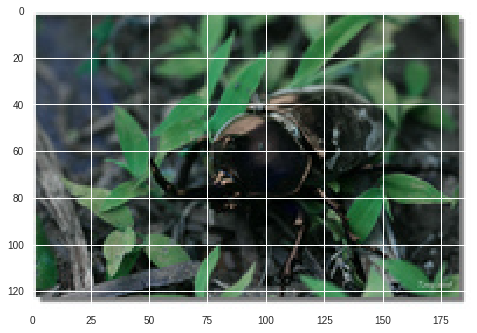

In [0]:
import glob
import cv2
folder='imagenet128/train'
filenames = (glob.glob(folder + "/*/*.JPEG"))

print(filenames[10])
word=filenames[10].split('/')
print(word)
print(synset_id_to_cls[word[2]])
a1 = cv2.imread(filenames[5000])
print(a1.shape)
print(type(a1))
plt.imshow(a1)
plt.show()

In [0]:
import glob
import cv2
# Data loader
class ImageFolderLoader(torch.utils.data.Dataset):
    def __init__(self, folder, mydic, transform=None):
        self.transform = transform
        self.filenames = (glob.glob(folder + "/*/*.JPEG"))
        self.dic=mydic
    def __len__(self):
        return len(self.filenames)
        
    def __getitem__(self, idx):
        data = cv2.imread(filenames[idx])
        label= np.array(synset_id_to_cls[filenames[idx].split('/')[2]])
        label=torch.from_numpy(label).long()
        
        #print(data.shape)
        
        if self.transform:
            data = self.transform(data)
            
        #print(data.shape)
        
        return data, label

In [0]:
transform_type=0

if transform_type==0:
  train_transforms = transforms.Compose( 
    [transforms.ToPILImage(), transforms.Resize(128), transforms.CenterCrop(128),
    transforms.ToTensor()])
  
  test_transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize(128), transforms.CenterCrop(128),
    transforms.ToTensor()])
  
  


data_train = ImageFolderLoader('imagenet128/train', synset_id_to_cls, transform=train_transforms)
#assert(len(data_train) == 1281167)
data_test = ImageFolderLoader('imagenet128/val', synset_id_to_cls, transform=test_transforms)
#assert(len(data_test) == 50000)

mydata, mylabel = data_train.__getitem__(0)
print(mydata)
print(mydata.shape)
print("--------------------------------------------------------")
print(mylabel)

tensor([[[0.0235, 0.0275, 0.0353,  ..., 0.0353, 0.0353, 0.0157],
         [0.0157, 0.0157, 0.0196,  ..., 0.0471, 0.0275, 0.0157],
         [0.0275, 0.0275, 0.0314,  ..., 0.0706, 0.0275, 0.0392],
         ...,
         [0.6471, 0.6392, 0.6353,  ..., 0.6667, 0.6745, 0.6980],
         [0.6627, 0.6549, 0.6667,  ..., 0.6353, 0.6824, 0.6902],
         [0.6627, 0.6627, 0.6902,  ..., 0.6471, 0.5608, 0.5765]],

        [[0.0078, 0.0039, 0.0078,  ..., 0.1961, 0.1961, 0.1804],
         [0.0039, 0.0000, 0.0000,  ..., 0.2118, 0.1961, 0.1882],
         [0.0157, 0.0078, 0.0039,  ..., 0.2627, 0.2196, 0.2353],
         ...,
         [0.7412, 0.7412, 0.7373,  ..., 0.7451, 0.7529, 0.7765],
         [0.7294, 0.7333, 0.7451,  ..., 0.7020, 0.7490, 0.7569],
         [0.7255, 0.7255, 0.7529,  ..., 0.7059, 0.6196, 0.6353]],

        [[0.0275, 0.0235, 0.0275,  ..., 0.1137, 0.1137, 0.0902],
         [0.0118, 0.0118, 0.0118,  ..., 0.1412, 0.1137, 0.0980],
         [0.0235, 0.0157, 0.0157,  ..., 0.1843, 0.1333, 0.

In [0]:
class myVGGlikeCNN(torch.nn.Module):
    
    #Our batch shape for input x is (256, 64, 64)
    
    def __init__(self):
        super(myVGGlikeCNN, self).__init__()
       
        #The first layer has a convultional network, a batch norm layer
        #
        self.conv_layers = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(), 
          nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), 
          nn.ReLU(), 
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          )
        
        self.fc_layers = nn.Sequential( 
          nn.Linear(8*8*128, 2048),
          nn.BatchNorm1d(2048),
          nn.ReLU(),
          nn.Dropout(p=0.75),
          nn.Linear(2048,1000)
          )
        
        
    def forward(self, x):
        
        #print(x.shape)
        batch_size=x.shape[0]
        #print("printing input")
        #print(x)
        
        out = self.conv_layers(x)
        #print("after after 1st conv layer")
        #print(out.shape)
        #print(out.shape)
        
        out = out.view(-1, 128*8*8)
        #print("after flattening")
        #print(x.shape)
        
        out = self.fc_layers(out)
        #print("printing after 1st fc layer")
        #print(out.shape)
        
        return out


In [0]:
#class FullImagenetNet(myLinearClassifier):
#class FullImagenetNet(mySimpleCNN):
class FullImagenetNet(myVGGlikeCNN):
  
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        # TODO save the model if it is the best
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy
        #raise NotImplementedError('Need to implement save_best_model')

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


In [0]:
myImagenetNet=FullImagenetNet()
del myImagenetNet

In [0]:
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
PRINT_INTERVAL = 1000
WEIGHT_DECAY = 0.0005
CHECKPOINT_PATH = BASE_PATH + 'imagenet_full/checkpoints'
LOG_PATH = BASE_PATH + 'imagenet_full/' + 'log.pkl'

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
#print('Using device', device)
import multiprocessing
#print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}


class_names = sorted([(int(key), val['label'].split(',')[0]) for key, val in imagenet_synset_data.items()])
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]
#print(class_names)

"""
indices=range(0, data_train.__len__())
train_sampler=torch.utils.data.RandomSampler(indices)

indices=range(0, data_test.__len__())
test_sampler=torch.utils.data.RandomSampler(indices)
"""

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)


train_loss_list = []
test_loss_list = []
test_accuracy_list =[]





model = FullImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(CHECKPOINT_PATH)

if start_epoch==0:
    with open('mylogs', "wb") as f:
        pickle.dump(train_loss_list, f)
        pickle.dump(test_loss_list, f)
        pickle.dump(test_accuracy_list, f)

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        
        with open('mylogs', "rb") as f:
            train_loss_list = pickle.load(f)
            test_loss_list = pickle.load(f)
            test_accuracy_list = pickle.load(f)
        
        
        my_train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        my_test_loss, my_test_accuracy = test(model, device, test_loader, False)
        
        train_loss_list.append(my_train_loss)
        test_loss_list.append(my_test_loss)
        test_accuracy_list.append(my_test_accuracy)
        
        with open('mylogs', "wb") as f:
            pickle.dump(train_loss_list, f)
            pickle.dump(test_loss_list, f)
            pickle.dump(test_accuracy_list, f)
        
        model.save_best_model(my_test_accuracy, CHECKPOINT_PATH + '/%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(CHECKPOINT_PATH + '/%03d.pt' % epoch, 0)
    


Using device cuda
num cpus: 2
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', '

Process Process-15:
Traceback (most recent call last):


Interrupted


  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-87-bf47fade20af>", line 13, in __getitem__
    data = cv2.imread(filenames[idx])
KeyboardInterrupt
Process Process-16:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data

Saved /gdrive/My Drive/colab_files/homework1/imagenet_full/checkpoints/006.pt



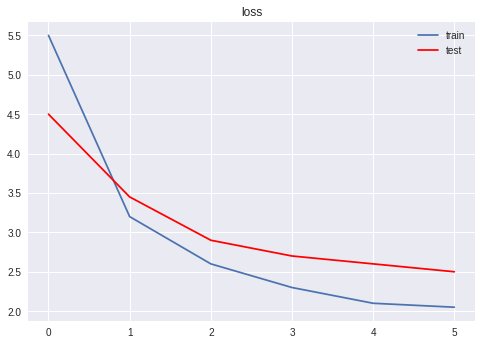

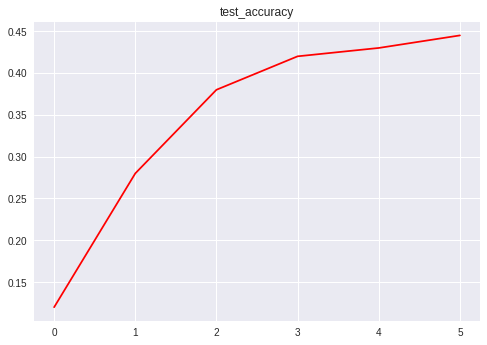

In [10]:
with open('mylogs', "rb") as f:
    train_loss_list = pickle.load(f)
    test_loss_list = pickle.load(f)
    test_accuracy_list = pickle.load(f)


plt.plot(train_loss_list, label='train')
plt.plot(test_loss_list, c='r', label='test')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(test_accuracy_list, c='r')
plt.title('test_accuracy')
plt.show()

# Part 7: Short answer questions
Please answer these questions, and put the answers in a file called homework1_python.pdf in your repository.

# Tiny ImageNet
1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.
2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.
3. Why do you think the best one worked well and the worst one worked poorly.


# Full ImageNet
1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from Tiny ImageNet question 1.
2. Were you able to use larger/deeper networks on Full ImageNet than you used on Tiny ImageNet and increase accuracy? If so, why? If not, why not?
3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet (32x32)? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

Additionally, download your .ipynb and put it in your repository and name it homework1_colab.ipynb

